In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [2]:
import torch
torch.__version__

'2.0.0'

In [34]:
# print("Cuda Current Device: ", torch.cuda.current_device()) 
print("Cuda Device Count: ", torch.cuda.device_count()) 
# print("Cuda Device Name: ", torch.cuda.get_device_name(0)) 
print("Cuda Device Available : ", torch.cuda.is_available()) 

Cuda Device Count:  0
Cuda Device Available :  False



# Training a Classifier

Assumption: You know how to define neural networks, compute loss and make updates to the weights of the network.

## Data

Generally, when you deal with image, text, audio or video data, you can use standard python packages that load data into a numpy array. Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have a package called ``torchvision``, that has data loaders for common datasets such as ImageNet, CIFAR10, MNIST, etc. and data transformers for images, viz. ``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This makes it convenient to get data and avoid writing boilerplate code.

We will use the CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.


## Training an image classifier

We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

### 1. Load and normalize CIFAR10

Using ``torchvision``, it’s extremely easy to load CIFAR10.


In [4]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



<div class="alert alert-info"><h4>Note</h4><p>If running on Windows and you get a BrokenPipeError, try setting
    the num_worker of torch.utils.data.DataLoader() to 0.</p></div>



In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:07<00:00, 23621051.41it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us view some of the training images



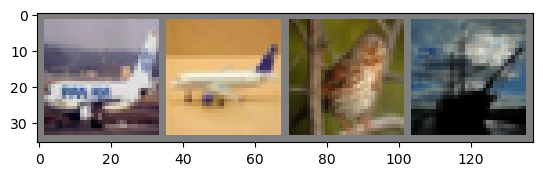

plane plane bird  ship 


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img * 0.5 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 2. Define a Convolutional Neural Network
Create a neural network to take 3-channel images.



In [8]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        kernel_size = 5
        self.conv1 = nn.Conv2d(3, 6, kernel_size) #(Input Channel, Output Channel, Kernel)
        self.pool = nn.MaxPool2d(2, 2) # (kernel, stride)
        self.conv2 = nn.Conv2d(6, 16, kernel_size)
        self.fc1 = nn.Linear(16 * kernel_size * kernel_size, 120) # Flatten the image
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [9]:
# Explanation of layers calculations
O_conv1 = (32 - 5 + 0) /  1 + 1 # (Image_dimension -  Kernel + Padding) / Stride + 1
O_pool1 = O_conv1 // 2 # Pool halfs the dimension
O_conv2 = (O_pool1 - 5 + 0) /  1 + 1 # (Image_dimension -  Kernel + Padding) / Stride + 1
O_fcl1 = O_conv2 // 2
O_conv1, O_pool1, O_conv2, O_fcl1


(28.0, 14.0, 10.0, 5.0)

### 3. Choose a Loss function and optimizer
Let us use classification cross - entropy loss and Stochastic Gradient Descent (SGD) with momentum.



In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [11]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # set the parameter gradients to zero
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.178
[1,  4000] loss: 1.840
[1,  6000] loss: 1.664
[1,  8000] loss: 1.589
[1, 10000] loss: 1.502
[1, 12000] loss: 1.490
[2,  2000] loss: 1.418
[2,  4000] loss: 1.383
[2,  6000] loss: 1.364
[2,  8000] loss: 1.340
[2, 10000] loss: 1.333
[2, 12000] loss: 1.311
Finished Training


## Save the trained model
Let's save our trained model:



In [12]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

See [here](https://pytorch.org/docs/stable/notes/serialization.html)
for more details on saving PyTorch models.

### 5. Test the network on the test data

We have trained the network for two passes over the training dataset. We need to check what the network has learnt.

We will check this by predicting the class label that the neural network outputs, and check it against the test data set. If the prediction is correct, we add the sample to the list of correct predictions.

Let us display an image from the test set to get familiar.



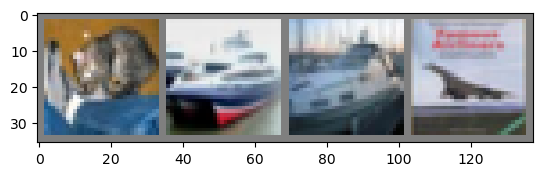

Test Labels:  cat   ship  ship  plane


In [13]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('Test Labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let us learn how to load our saved model
Note: saving and loading the model isn't necessary, we only did it to illustrate how to do so.



In [14]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:



In [15]:
outputs = net(images)

The outputs are the energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let's get the index of the highest energy.



In [16]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   car   car   ship 


The results are much better than the random guess (10%).

Let us look at how the network performs on the whole dataset.



In [17]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 54 %


This is way better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the neural network learnt something.

Let us check what classes performed well, and what classes did not perform well.



In [18]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 53.0 %
Accuracy for class: car   is 68.1 %
Accuracy for class: bird  is 28.6 %
Accuracy for class: cat   is 21.6 %
Accuracy for class: deer  is 42.2 %
Accuracy for class: dog   is 59.0 %
Accuracy for class: frog  is 73.8 %
Accuracy for class: horse is 66.3 %
Accuracy for class: ship  is 74.9 %
Accuracy for class: truck is 58.6 %


Okay, so what next?

How do we run these neural networks on the GPU?

## Training on GPU
Just like how you transfer a Tensor onto the GPU, you transfer the neural net onto the GPU.

Let's first define our device as the first visible cuda device if we have CUDA available.



In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


The rest of this section assumes that ``device`` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:

.. code:: python

    net.to(device)


Remember that you will have to send the inputs and targets at every step
to the GPU too:

.. code:: python

        inputs, labels = data[0].to(device), data[1].to(device)

Why don't I notice MASSIVE speedup compared to CPU? Because your network
is really small.

**Exercise:** Try increasing the width of your network (argument 2 of the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` – they need to be the same number), see what kind of speedup you can get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

## Training on multiple GPUs
If you want to see even more MASSIVE speedup using all of your GPUs, please check out :doc:`data_parallel_tutorial`.

## Where do we go next?

-  `Train a state-of-the-art ResNet network`_
-  `Train a state-of-the-art VGG`_
-  `Train a state-of-the-art MobileNet`_
-  `Train a state-of-the-art ResNet network on imagenet`_
-  `More examples`_
-  `More tutorials`_
-  `Discuss PyTorch on the Forums`_




# OPTIMIZE, Traning with a new CNN model
Based on the given notbook,  I will import a pre-trained CNN architecture (**ResNet18**) and compare its performance with the simple architecture implemented in the notebook. I will also experiment with different parameters such as the number of hidden layers, number of nodes, epochs, batch sizes, and activation functions.


## Define a ResNet18 model.
First, let's import a pre-trained CNN model. In this case, I will use the ResNet18 model available in the torchvision library.

In [20]:
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.models.resnet import ResNet18_Weights

# Load pre-trained ResNet18 model
resnet18 = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Modify the last layer to match the number of classes in CIFAR-10 dataset (10 classes)
num_classes = 10
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\benso/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 27.6MB/s]


## Define the number of nodes in the layers
To modify the number of nodes in the ResNet18 model, we can change the number of output channels in the inital convolutional layer:

In [21]:
resnet18.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)


In [22]:
def train_model(model, trainloader, num_epochs, learning_rate):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / (i + 1):.4f}')

    print('Finished training')
    
# Train the simple model (CIFAR-10 classification) with a different number of epochs
# simple_model_epochs = 5
# simple_model = Net();
# print(f'Training simple model for {simple_model_epochs} epochs')
# train_model(simple_model, trainloader, simple_model_epochs, learning_rate=0.001)

# Train the ResNet18 model with a different number of epochs
# resnet18_epochs = 10
# print(f'\nTraining ResNet18 model for {resnet18_epochs} epochs')
# train_model(resnet18, trainloader, resnet18_epochs, learning_rate=0.1)


## Train the net work with different parameters.
We could train the modle with different epochs, activation function and so on.

### Different number of epochs for the trainning function.
We could train previous CIFAR10 the ResNet18 model with different numbers of epochs, for example 5, 10 and 20. And compare their performances.

Notes: bigger number of epochs will take longer training time.

Frist, let's define a train_model trainning function that accept different model, trainloader, num of epochs, and learning_rate.

### Diffenet activation function.

For the `CNN` model that we defined before, it could simple to define different activation function such as **'relu',** **'sigmoid'** or **'tanh'** with the following code. Then we could pass the desired activation function as 


```
simple_model_relu = SimpleModel(activation_function='relu')
simple_model_sigmoid = SimpleModel(activation_function='sigmoid')
simple_model_tanh = SimpleModel(activation_function='tanh')
```



In [23]:
class SimpleModel(nn.Module):
    def __init__(self, activation_function='relu', num_classes=10):
        super(SimpleModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
        
        if activation_function == 'relu':
            self.activation = nn.ReLU()
        elif activation_function == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation_function == 'tanh':
            self.activation = nn.Tanh()
        else:
            raise ValueError("Invalid activation function. Supported options: 'relu', 'sigmoid', 'tanh'")

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

For the `ResNet18`, it uses only one activation function throughout the architecture, which is the **ReLU** activation function.  

Then let's train the new SimpleMode with 'sigmod' activation function with 5 epchos, and Res18Net model with default relu' activation function and 10 epchos.

In [24]:
# Train the simple model (CIFAR-10 classification) with 'sigmoid' activation funation and 5 epochs
simple_model_epochs = 5
simple_model_sigmoid = SimpleModel(activation_function='sigmoid')
print(f'Training simple model for {simple_model_epochs} epochs')
train_model(simple_model_sigmoid, trainloader, simple_model_epochs, learning_rate=0.001)

# Train the ResNet18 model with 10 epochs
resnet18_epochs = 10
print(f'\nTraining ResNet18 model for {resnet18_epochs} epochs')
train_model(resnet18, trainloader, resnet18_epochs, learning_rate=0.1)



Training simple model for 5 epochs
Epoch 1/5, Loss: 2.3134
Epoch 2/5, Loss: 2.3089
Epoch 3/5, Loss: 2.3067
Epoch 4/5, Loss: 2.3054
Epoch 5/5, Loss: 2.3049
Finished training

Training ResNet18 model for 10 epochs
Epoch 1/10, Loss: 2.4845
Epoch 2/10, Loss: 2.3588
Epoch 3/10, Loss: 2.3579
Epoch 4/10, Loss: 2.3616
Epoch 5/10, Loss: 2.3605
Epoch 6/10, Loss: 2.3597
Epoch 7/10, Loss: 2.3607
Epoch 8/10, Loss: 2.3606
Epoch 9/10, Loss: 2.3598
Epoch 10/10, Loss: 2.3602
Finished training


## Save the trained model
Let save the simple_model with 'sigmoid' to the 'simple_model.pth'. And resnet18 model to resent18.pth.

In [25]:
# Save the simple_model
torch.save(simple_model_sigmoid.state_dict(), 'simple_model.pth')

# Save the resnet18 model
torch.save(resnet18.state_dict(), 'resnet18.pth')

## Test the new train network and Res18Network on the test data.
Load the modles from the trains before.

In [26]:
# Load the simple_model
loaded_simple_model = SimpleModel()
loaded_simple_model.load_state_dict(torch.load('simple_model.pth'))
#loaded_simple_model.eval()  # Set to evaluation mode

# Load the resnet18 model
loaded_resnet18 = torchvision.models.resnet18(pretrained=False,  num_classes=num_classes)
##loaded_resnet18.fc = nn.Linear(loaded_resnet18.fc.in_features, num_classes)
loaded_resnet18.load_state_dict(torch.load('resnet18.pth'))
#loaded_resnet18.eval()  # Set to evaluation mode

c:\Users\benso\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\benso\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

### Predict with the CNN model with 'signmod' and 5 epchos

In [27]:
# Print the true labels
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# Load the saved model and make predictions
loaded_simple_model.eval()
new_outputs = loaded_simple_model(images)

_, predicted = torch.max(new_outputs, 1)
print('Predicted with CNN-signmod: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

GroundTruth:  cat   dog   car   horse
Predicted with CNN-signmod:  horse horse horse horse


From the predicted result, it is not match. So lets Test it with the entire data and find the Accuracy.

In [28]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = loaded_simple_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))



Accuracy of the network on the 10000 test images: 10 %


### Predict with the ResNet18 model

In [29]:
# Print the true labels
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# Make predictions using the loaded_resnet18 model
outputs2 = loaded_resnet18(images)

# Get the predicted class labels
_, predicted2 = torch.max(outputs2, 1)

print('Predicted with ResNet18: ', ' '.join('%5s' % classes[predicted2[j]] for j in range(4)))

GroundTruth:  cat   dog   car   horse
Predicted with ResNet18:   deer  deer  deer  deer


Test ResNet18  with the entire data and find the Accuracy.

In [30]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = loaded_resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 10 %


Let check the accuracy of the class of the two new Model:

In [31]:
# Function to compute accuracy for each class
def compute_class_accuracies(model, testloader, classes):
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # again no gradients needed
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    # print accuracy for each class
    print(f'Accuracy for model: {model.__class__.__name__}')
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'  {classname:5s}: {accuracy:.1f} %')
    print()

# Compute accuracies for simple_model
compute_class_accuracies(loaded_simple_model, testloader, classes)

# Compute accuracies for ResNet18
compute_class_accuracies(loaded_resnet18, testloader, classes)

Accuracy for model: SimpleModel
  plane: 0.0 %
  car  : 0.0 %
  bird : 0.0 %
  cat  : 0.0 %
  deer : 0.0 %
  dog  : 0.0 %
  frog : 0.0 %
  horse: 100.0 %
  ship : 0.0 %
  truck: 0.0 %

Accuracy for model: ResNet
  plane: 0.0 %
  car  : 0.0 %
  bird : 0.0 %
  cat  : 0.0 %
  deer : 100.0 %
  dog  : 0.0 %
  frog : 0.0 %
  horse: 0.0 %
  ship : 0.0 %
  truck: 0.0 %



### Conclution

Based on the current performance of the SimpleModel and ResNet models, it appears that there is an issue with the training process or the evaluation of the models, as they are only predicting a single class.

Here are some suggestions for the future:
1.   Verify the training process: Make sure that the loss values during training are decreasing and that the models are converging. If the loss values are not decreasing, adjust the learning rate, batch size, and number of epochs.

2.   Inspect the data: Ensure that the data is properly loaded and preprocessed. Verify that both the training and test datasets are correctly split, shuffled, and normalized. Also, make sure there are no issues with the dataset's labels.

3. Experiment with hyperparameters: Try adjusting the learning rate, batch size, number of epochs, and other hyperparameters. This may improve the model's performance on the test set.

4. Model architecture: For the SimpleModel, consider experimenting with different architectures or adding more layers to improve its performance. For the ResNet model, make sure the pretrained model is properly fine-tuned to the CIFAR-10 dataset.

5. Regularization: If overfitting is observed, consider adding dropout layers or other regularization techniques to the models to help them generalize better to the test data.

6. Data augmentation: To improve the model's generalization, you can apply data augmentation techniques, such as random rotations, translations, and flips, to the training dataset.

7. Monitor the performance: Keep track of the performance metrics, such as accuracy, precision, recall, and F1-score, to gain insights into the model's behavior and potential areas for improvement.

Finally, remember that deep learning model development is an iterative process. We may need to experiment with different combinations of hyperparameters, architectures, and techniques to achieve the best performance on the task at hand.